# Health study report
Magdalena Persson

In [1]:
import sys
sys.path.append("src")

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from math import sqrt
from scipy import stats
from scipy.stats import ttest_ind
from src.io_utils import load_data, coerce_numeric
import seaborn as sns
from src import metrics as M
from src.viz import HealthAnalyzer
from sklearn.linear_model import LinearRegression

In [2]:
df = load_data("data/health_study_dataset.csv")
df = coerce_numeric(df)

print(df.isna().sum())

id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64


In [3]:
sum_df = M.summary(df[["age", "weight", "height", "systolic_bp", "cholesterol"]])

print("Medel, median, min och max för utvalda kategorier:")
display(sum_df)


Medel, median, min och max för utvalda kategorier:


,mean,median,min,max
age,49.426250,50.00,18.0,90.00
weight,73.413000,73.20,33.7,114.40
height,171.849250,171.35,144.4,200.40
systolic_bp,149.178625,149.40,106.8,185.90
cholesterol,4.929150,4.97,2.5,7.88


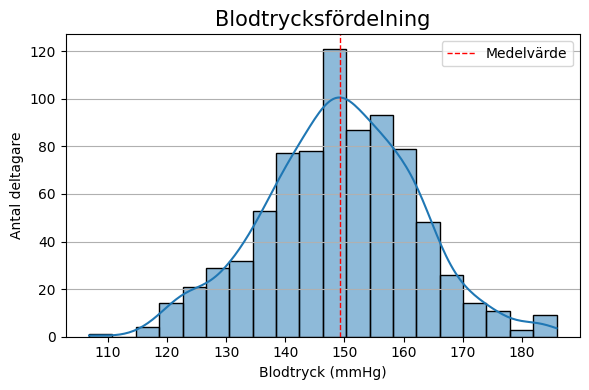

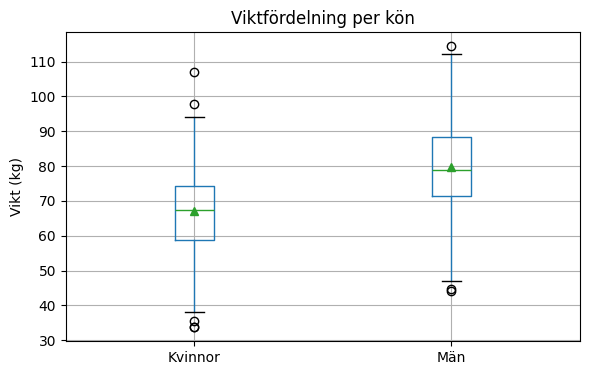

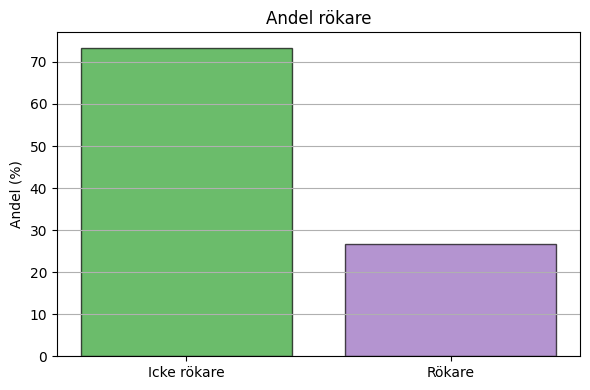

In [4]:

H = HealthAnalyzer(df)

fig, ax = plt.subplots(figsize=(6, 4))
H.hist_mean(
    ax, 
    df["systolic_bp"], 
    bins=20, 
    title="Blodtrycksfördelning", 
    xlabel="Blodtryck (mmHg)", 
    ylabel="Antal deltagare", 
    kde=True, 
    grid=True)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
H.box_plot(ax, df, "weight", "sex", "Viktfördelning per kön", "", "Vikt (kg)")
ax.set_xticklabels(["Kvinnor", "Män"])
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
H.bar_smoker(ax, M.smoker_count(df))
plt.show;



In [5]:
np.random.seed(42)

n = 1000
sick = M.with_disease(df) / len(df)

sim = np.random.choice([0, 1], size=n, p=[1 - sick, sick])
sim_mean = sim.mean() * 100

print(f"Antalet med sjukdomen är: {M.with_disease(df)} st dvs {sick*100:.2f}% av deltagarna")
print(f"Med simulation blir andelen sjuka {sim_mean:.2f}%")

Antalet med sjukdomen är: 47 st dvs 5.88% av deltagarna
Med simulation blir andelen sjuka 5.60%


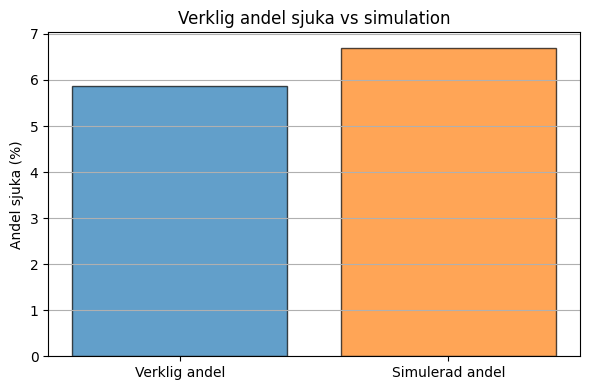

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
H.bar_disease_simulation(ax)
plt.show;

### Grafen ovan visar en jämförelse över den simulerade andelen och den verkliga andelen sjuka.
Den simulerade andelen är baserad på 1000 slumpmässigt valda personer med återläggning från datasetet.

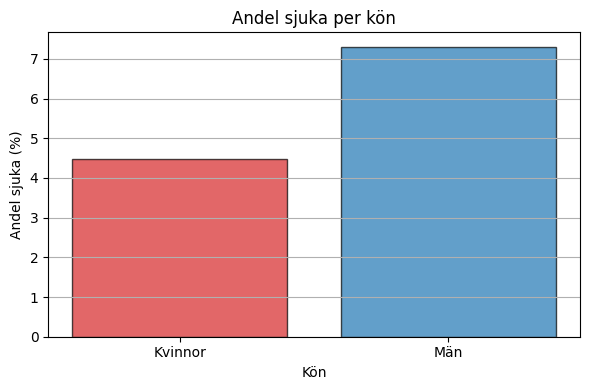

----Andelen sjuka----
Kvinnor:4.5%, Män:7.3%


In [7]:
fig, ax = plt.subplots(figsize=(6,4))
H.disease_per_gender_bar(ax)
plt.show()

print("----Andelen sjuka----")
print(M.disease_per_gender(df));


### Graf över andel sjuka per kön

Vi kan enligt grafen ovan se att män har en högre tendens till att få sjukdomen än kvinnor. 

In [8]:
x = df["systolic_bp"].dropna().to_numpy()
b_means, boot_mean, ci_low, ci_high = M.ci_mean_bootstrap(x)

mean_x, lo_norm, hi_norm, sd, se = M.ci_mean_normal(x)

print("Konfidensintervall för blodtryck (bootstrap):")
print(f"Medel: {boot_mean:.2f}, 95% CI: {ci_low:.2f}, {ci_high:.2f}")
print("")
print("Konfidensintervall för blodtryck (normal-approximation):")
print(f"Medel: {mean_x:.2f}, 95% CI: {lo_norm:.2f}, {hi_norm:.2f}")


Konfidensintervall för blodtryck (bootstrap):
Medel: 149.18, 95% CI: 148.28, 150.06

Konfidensintervall för blodtryck (normal-approximation):
Medel: 149.18, 95% CI: 148.29, 150.07


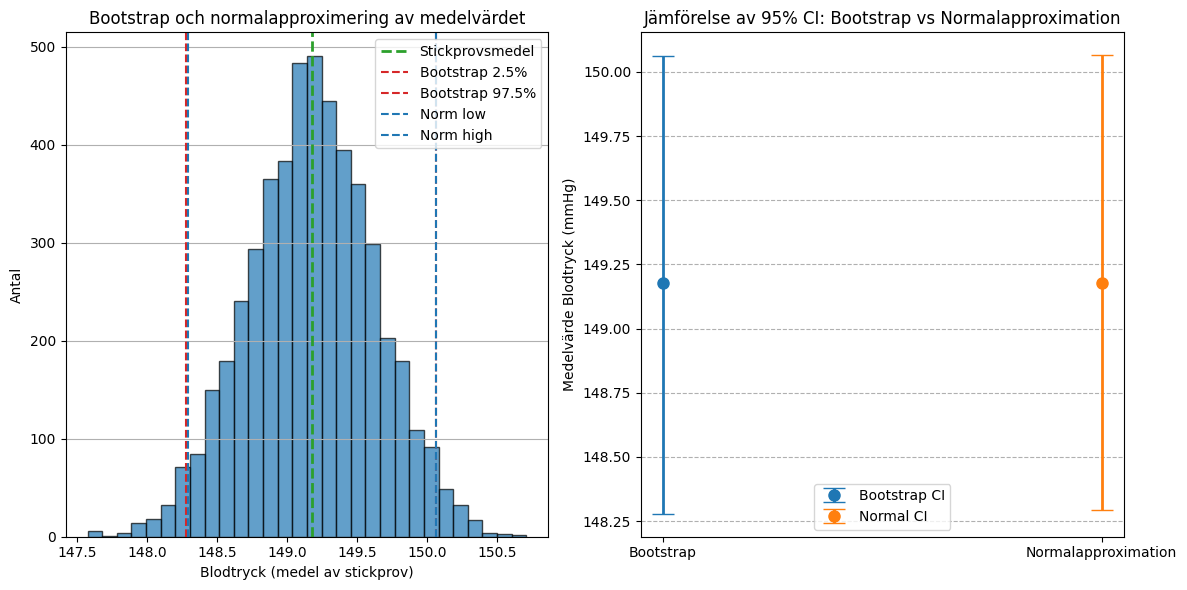

In [9]:
fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=False) 
H.plot_bootstrap_vs_normal(
    axes[0], axes[1],
    b_means=b_means,
    mean_x=mean_x,
    ci_low=ci_low,
    ci_high=ci_high,
    lo_norm=lo_norm,
    hi_norm=hi_norm
       )

plt.tight_layout()
plt.show()

### Graferna ovan visar jämförelsen när konfidensintervallet för blodtryck tagits ut med Bootstrap och Normalapproximation.

Som man kan se utläser vi en väldigt liten skillnad mellan de olika metoderna, vilket innebär att man i detta fall bör använda sig av Normalapproximation.

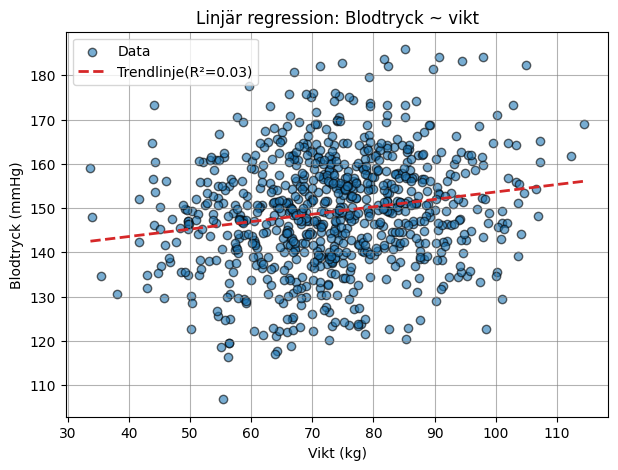

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
H.plot_lr_systolicbp_weight(ax)
plt.show()

### Grafen ovanför visar en linjär regression för att förutsäga hur vikten påverkar blodtrycket.

Man kan utläsa att vikten har en påverkan på högre blodtryck då det finns en positiv lutning. 

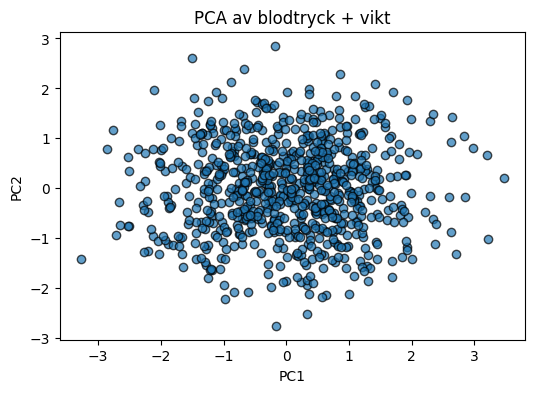

Förklarad varians per komponent:
  PC1: 58.97%
  PC2: 41.03%

Komponentvikter (PCA-axlar):

PC1:
  systolic_bp  -> 0.707
  weight       -> 0.707

PC2:
  systolic_bp  -> 0.707
  weight       -> -0.707


In [11]:
fig, ax = plt.subplots(figsize=(6,4))
H.pca_plot(ax)
plt.show()

expl, comps = M.pca_systolicbp_weight(df)
M.print_pca_bw(expl, comps)

### Grafen ovan visar PCA av blodtryck + vikt
Utifrån denna datan kan vi se att:
- PC1: 58.97% - PC1 fångar ca 59% av variationen dvs den axel som fångar mest variation
- PC2: 41.03% - PC2 fångar ca 41% av variationen
- PCA 1 -> båda variablerna bidrar lika mycket
- PCA 2 -> skillnaden mellan variablerna

In [12]:
s_yes = (df["smoker"] == "Yes").sum()
s_no = len(df) - s_yes

print(f"Antal rökare är {s_yes} st och icke-rökare {s_no} st deltagare.")

smoker_stats = df.groupby("smoker")["systolic_bp"].agg(["count", "mean", "median", "std", "min", "max"])
smoker_stats


Antal rökare är 213 st och icke-rökare 587 st deltagare.


,count,mean,median,std,min,max
smoker,,,,,,
No,587,149.052981,149.3,12.626038,116.3,185.9
Yes,213,149.524883,149.5,13.267800,106.8,184.2


In [13]:
low, high = df["systolic_bp"].quantile([0.01, 0.99])
clipped = df[(df["systolic_bp"] >= low) & (df["systolic_bp"] <= high)]

compare_means = pd.DataFrame({
    "original_mean_Y": [df.loc[df.smoker == "Yes", "systolic_bp"].mean()],
    "original_mean_N": [df.loc[df.smoker == "No", "systolic_bp"].mean()],
    "clipped_mean_Y": [clipped.loc[clipped.smoker == "Yes", "systolic_bp"].mean()],
    "clipped_mean_N": [clipped.loc[clipped.smoker == "No", "systolic_bp"].mean()]
})

compare_means

,original_mean_Y,original_mean_N,clipped_mean_Y,clipped_mean_N
0,149.524883,149.052981,149.194634,149.145423


In [14]:
s_yes = df.loc[df["smoker"] == "Yes", "systolic_bp"].dropna().to_numpy()
s_no = df.loc[df["smoker"] == "No", "systolic_bp"].dropna().to_numpy()

obs_diff, boot_diffs, p_boot, ci_low, ci_high = M.bootstrap_mean_difference(s_yes, s_no)

print(f"Observerad skillnad mellan rökare och icke-rökare: {obs_diff:.2f} mmHg")
print(f"95% konfidensintervall: [{ci_low:.2f}, {ci_high:.2f}]")
print(f"Bootstrap p-värde: {p_boot:.4f}")

Observerad skillnad mellan rökare och icke-rökare: 0.47 mmHg
95% konfidensintervall: [-1.64, 2.45]
Bootstrap p-värde: 0.6862


In [15]:
t_stat, p_val= stats.ttest_ind(s_no, s_yes, equal_var=False)

print(f"Welch t-test: t = {t_stat:.2f}, p = {p_val:.2}")

Welch t-test: t = -0.45, p = 0.65


In [16]:
power = M.estimate_power_by_simulation(
    n_no=len(s_no),
    n_yes=len(s_yes),
    mean_no=s_no.mean(),
    mean_yes=s_yes.mean(),
    std_no=s_no.std(ddof=1),
    std_yes=s_yes.std(ddof=1),
)

print("Power ->", power)



Power -> 0.0644


### Hypotes: ”Rökare har högre medel-blodtryck än icke-rökare.”

- Den observerade skillnaden mellan rökare och icke rökare, där rökare har 0.47 mmHg högre blodtryck, är väldigt liten.
- P-värdet är uttaget via två olika test, bootstrap och t-test och visar högt vilket betyder att slumpen kan ha orsakat. Nollhypotesen kan ej förkastas i detta fall.
- Då 0 ligger inom konfidensintervallet finns det inget statistiskt stöd och man kan inte utesluta att den sanna skillnaden är 0.
- Power på ca 7% visar att testet har mycket låg känslighet och missar skillnaden i de flesta simuleringar.

### Slutsats:
- Man behöver mer data för att se om det finns någon verklig skillnad på blodtrycket mellan rökare och icke rökare. 

### Dokumentation


- För information om t-test användes:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

- Power:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.power.html#scipy.stats.power

- PCA:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

- Videolektioner v.6, v.7 och v.8
